## pre-requirements

- Colab 런타임 GPU 선택 (cuda 사용)
- 미설치 라이브러리 : mxnet, sentencepiece, transformers==3.0.2, torch
- 구글 드라이브 연결 : /gdrive
- 핵심 라이브러리 : torch

## [BERT활용하여 텍스트 다중 분류 구현 with 허깅페이스](https://dacon.io/competitions/official/235938/codeshare/5619?page=1)

__참고:__

- [Multi-class Text Classification using BERT and TensorFlow](https://towardsdatascience.com/multi-label-text-classification-using-bert-and-tensorflow-d2e88d8f488d)


In [2]:
# 한글 나눔 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 한글 폰트 위치
!ls /usr/share/fonts/truetype/nanum/

NanumBarunGothicBold.ttf  NanumMyeongjoBold.ttf  NanumSquareRoundR.ttf
NanumBarunGothic.ttf	  NanumMyeongjo.ttf	 NanumSquareR.ttf
NanumGothicBold.ttf	  NanumSquareB.ttf
NanumGothic.ttf		  NanumSquareRoundB.ttf


In [18]:
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# ==> 런타임 재시작 필요!! (이후 재실행 필요없음)

In [1]:
# tensorflow_text 2.9.0
# tensorflow 2.9.1
# tensorflow_estimator 2.9.0
# tensorboard 2.9.1
# keras 2.9.0
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.6 MB 8.0 MB/s 
     |████████████████████████████████| 511.7 MB 6.0 kB/s 
     |████████████████████████████████| 438 kB 70.0 MB/s 
     |████████████████████████████████| 5.8 MB 53.1 MB/s 
     |████████████████████████████████| 1.6 MB 58.2 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninst

In [2]:
# translate 3.6.1
!pip install translate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

import random
import numpy as np
import pandas as pd
# pytorch 사용할거라 tensorflow 임포트 안함

rand_seed = 42
random.seed(rand_seed)
np.random.seed(rand_seed)


In [4]:
from google.colab import drive
drive.mount('/gdrive')

# 파일을 못찾을 경우, 이렇게 확인을 해야 함!!
import os
os.chdir("/gdrive/MyDrive/Colab Notebooks/제주ICT-AI분석반-쇼핑몰분석")
!ls -l data

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
total 63536
-rw------- 1 root root  188900 Jul  7 08:13 sample_submission.csv
drwx------ 2 root root    4096 Jul 27 10:41 submissions
-rw------- 1 root root  188892 Jul 29 12:12 submission_v5.2_bert_hanspell.csv
-rw------- 1 root root  188892 Jul 29 12:36 submission_v5.3-bert_hanspell.csv
-rw------- 1 root root  188891 Jul 28 02:49 submission_v6_4.csv
-rw------- 1 root root  188891 Jul 28 03:16 submission_v6_5.csv
-rw------- 1 root root  188892 Jul 29 13:34 submission_v6.6-electra_hanspell.csv
-rw------- 1 root root 2679138 Jul  7 08:13 test.csv
-rw------- 1 root root 5322082 Jul 29 10:00 test_hanspell.csv
-rw------- 1 root root 8288753 Jul 24 11:11 test_mecab.csv
-rw------- 1 root root 7841571 Jul 24 11:35 test_okt.csv
-rw------- 1 root root 7650515 Jul 25 08:57 test_okt_stem.csv
-rw------- 1 root root 2738015 Jul  7 08:13 train.csv
-rw------- 1 root root 5390496 Jul 29 0

## 리뷰 평점 예측을 위한 BERT 모델

### 전체 과정

1. 데이터 준비
  - train_df 읽어오기
  - train, valid 분리
  - target(y) 전처리
2. 텍스트 벡터화
  - sequence 변환, 패딩
  - word2vec 로부터 embedding_matrix 준비
3. 모델 생성
  - Embedding Layer
  - 1D CNN Layer
  - Output Layer
4. 모델 훈련
  - optimizer, loss, metrics
  - fit
  - evaluate
5. 모델 활용(예측/분류)
  - 데이터 불러오기: test_df
  - 동일한 전처리와 벡터화 적용
  - predict
6. 모델 시각화 (실제값/예측값)
  - 예측값 시각화
  - 실제값 시각화
  

### 0. translate 테스트


In [5]:
# data_path = '~/Workspaces/keras/dacon-shopping-mall/review_data'
data_path = "/gdrive/MyDrive/Colab Notebooks/제주ICT-AI분석반-쇼핑몰분석/data"

# 리뷰 평점 원본 데이터
file_path = f'{data_path}/train_hanspell.csv'

# 맞춤법/띄어쓰기 전처리 파일 
train_df = pd.read_csv(file_path)
print(train_df.shape)

train_df
# 24988 rows × 6 columns

(24988, 6)


,id,reviews,target,reviews_hanspell,tkn_size,chr_size
0,0,조아요 처음구입 싸게햇어요,2,좋아요 처음 구입 싸게 했어요,5,12
1,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 ...,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데 천 원가량 주고 사기 너무 아깝네요,13,35
2,2,디자인은괜찮은데 상품이 금이가서 교환했는데 두번째받은상품도 까져있고 안쪽에 금이가져...,2,디자인은 괜찮은데 상품이 금이 가서 교환했는데 두 번째 받은 상품도 까져있고 안쪽에...,19,64
3,3,기전에 이 제품말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다. 샘...,2,기전에 이 제품 말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다 샘...,36,102
4,4,튼튼하고 손목을 잘 받쳐주네요~,5,튼튼하고 손목을 잘 받쳐주네요,4,13
...,...,...,...,...,...,...
24983,24995,일단향이너무너무좋은데지속력만좋다면좋겠지만..워낙저렴해그래도좋아여,5,일단 향이 너무너무 좋은데 지 속력만 좋다면 좋겠지만 워낙 저렴해 그래도 좋아요,12,33
24984,24996,동일한 업체에서 발송하고 한 상자로 배송되었는데 택배비는 이중 처리되었습니다.,2,동일한 업체에서 발송하고 한 상자로 배송되었는데 택배비는 이중 처리되었습니다,9,34
24985,24997,향이 좋아요!! 다른 향도 시켜보고 싶어요,4,향이 좋아요 다른 향도 시켜보고 싶어요,6,16
24986,24998,펼쳐보니 끝부분쯤에 50cm정도 찟어져 있습니다 날짜관계로 구냥 사용합니다,2,펼쳐보니 끝부분쯤에 정도 찢어져 있습니다 날짜 관계로 구냥 사용합니다,9,30


In [6]:
from translate import Translator
from termcolor import colored

translator= Translator(from_lang="kr", to_lang="kr")

def print_rand_example(df, col_name, col_value, chars=180):
  '''print a random review and its translation given a label
  Args:
    - df: input dataframe
    - col_name: column to use as filter (e.g. Label)
    - col_value: value of col_name to use as filter 

    - chars (optional, def:180) max number of characters to display
  '''
  original = df[df[col_name]==col_value].sample()["reviews"].values[0]
  translation = translator.translate(original).replace("&#39;","'")
  print(colored("\nOriginal", 'green', attrs=['bold','underline']))
  print(original[0:chars] + "...")
  print(colored("\nTranslation", 'red', attrs=['bold','underline']))
  print(translation[0:chars] + "...")


# 한국어에서 한국어로 번역 테스트
print_rand_example(train_df, "target", 1)


Original
상품은 사진 그래도인데 냄새가 좀 나서 냄새빼고 썼어요 그런데 배송이 너무 엉망이었어요 업체와 배송기사사이에 소통이 안됐는지 배송시간과 장소가 지켜지지 않았습니다...

Translation
상품은 사진 그래도인데 냄새가 좀 나서 냄새빼고 썼어요 그런데 배송이 너무 엉망이었어요 업체와 배송기사사이에 소통이 안됐는지 배송시간과 장소가 지켜지지 않았습니다...


### 1. 데이터 준비

- train_df 읽어오기
- train, valid 분리
- target(y) 전처리


In [7]:
# data_path = '~/Workspaces/keras/dacon-shopping-mall/review_data'
data_path = "/gdrive/MyDrive/Colab Notebooks/제주ICT-AI분석반-쇼핑몰분석/data"

# 리뷰 평점 원본 데이터
file_path = f'{data_path}/train_hanspell.csv'

# 맞춤법/띄어쓰기 전처리 파일 
train_df = pd.read_csv(file_path)
print(train_df.shape)

train_df
# 24988 rows × 6 columns

(24988, 6)


,id,reviews,target,reviews_hanspell,tkn_size,chr_size
0,0,조아요 처음구입 싸게햇어요,2,좋아요 처음 구입 싸게 했어요,5,12
1,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 ...,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데 천 원가량 주고 사기 너무 아깝네요,13,35
2,2,디자인은괜찮은데 상품이 금이가서 교환했는데 두번째받은상품도 까져있고 안쪽에 금이가져...,2,디자인은 괜찮은데 상품이 금이 가서 교환했는데 두 번째 받은 상품도 까져있고 안쪽에...,19,64
3,3,기전에 이 제품말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다. 샘...,2,기전에 이 제품 말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다 샘...,36,102
4,4,튼튼하고 손목을 잘 받쳐주네요~,5,튼튼하고 손목을 잘 받쳐주네요,4,13
...,...,...,...,...,...,...
24983,24995,일단향이너무너무좋은데지속력만좋다면좋겠지만..워낙저렴해그래도좋아여,5,일단 향이 너무너무 좋은데 지 속력만 좋다면 좋겠지만 워낙 저렴해 그래도 좋아요,12,33
24984,24996,동일한 업체에서 발송하고 한 상자로 배송되었는데 택배비는 이중 처리되었습니다.,2,동일한 업체에서 발송하고 한 상자로 배송되었는데 택배비는 이중 처리되었습니다,9,34
24985,24997,향이 좋아요!! 다른 향도 시켜보고 싶어요,4,향이 좋아요 다른 향도 시켜보고 싶어요,6,16
24986,24998,펼쳐보니 끝부분쯤에 50cm정도 찟어져 있습니다 날짜관계로 구냥 사용합니다,2,펼쳐보니 끝부분쯤에 정도 찢어져 있습니다 날짜 관계로 구냥 사용합니다,9,30


In [11]:
# target 전처리
# ==> 숫자 [1~5] 를 [0~4] 로 변환 (예측할 때 원-핫 인코딩으로 출력)
train_df['label'] = train_df['target'].apply(lambda v: v-1)

# [0~4] label 확인 : num_classes=5
unq_labels, cnt_labels = np.unique(train_df['label'].values, return_counts=True)
print('labels =', dict(zip( unq_labels, cnt_labels )) )

train_df['label'].dtype

labels = {0: 4499, 1: 7994, 3: 2500, 4: 9995}


dtype('int64')

In [36]:
import tensorflow as tf

# 원-핫 인코딩: [0~4] ==> [0. 0. 0. 0. 0.]
num_classes = 5
y = tf.keras.utils.to_categorical(train_df['label'].values, num_classes=num_classes)

In [37]:
from sklearn.model_selection import train_test_split

data = train_df
X_train, X_valid, y_train, y_valid = train_test_split(
    data['reviews_hanspell'], 
    y,      # 원-핫 인코딩: to_categorical(label)
    test_size=0.2, 
    random_state=42, 
#     shuffle=True, 
    stratify=data['label']     # 클래스 비율 유지
)

# 크기를 확인합니다.
print( 'train 데이터 셋 모양 :', X_train.shape, y_train.shape)
print( 'valid 데이터 셋 모양 :', X_valid.shape, y_valid.shape)

train 데이터 셋 모양 : (19990,) (19990, 5)
valid 데이터 셋 모양 : (4998,) (4998, 5)


### Data modeling

Load BERT with TensorFlow Hub

In [38]:
import tensorflow_hub as hub
import tensorflow_text as text

preprocessor = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2")
encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-base/1")

def get_embeddings(sentences):
  '''return BERT-like embeddings of input text
  Args:
    - sentences: list of strings
  Output:
    - BERT-like embeddings: tf.Tensor of shape=(len(sentences), 768)
  '''
  preprocessed_text = preprocessor(sentences)
  return encoder(preprocessed_text)['pooled_output']


# shape=(1, 768)
get_embeddings([
    "물건 잘 받았습니다 운동화처럼 생겼네요 안전화라서 쿠션감은 떨어집니다"
    ])

<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[-2.50108749e-01, -2.47754008e-01,  6.94454685e-02,
        -2.40277439e-01, -2.83821702e-01, -1.96249709e-01,
        -3.80228996e-01, -1.22222304e+00,  2.57348120e-01,
        -5.05646646e-01, -1.91824108e-01, -4.31316406e-01,
        -3.20378363e-01, -7.49916732e-02, -4.60986227e-01,
        -9.75245833e-01,  4.21819985e-01, -3.87759000e-01,
        -2.81204656e-02, -2.08123505e-01, -2.17510566e-01,
         3.24467629e-01, -3.35276216e-01,  6.28549531e-02,
        -2.77239591e-01, -6.95729613e-01,  3.28169502e-02,
        -2.08340660e-01, -3.88591737e-01, -5.01326501e-01,
        -2.10635945e-01, -2.01076642e-01, -1.29804716e-01,
        -6.77521527e-01,  1.86357889e-02,  4.31245118e-02,
        -8.39388892e-02,  2.28247181e-01,  2.01140448e-01,
        -3.03233534e-01, -2.07829475e-01, -1.80258080e-02,
        -4.57547367e-01,  6.27092779e-01,  2.52228603e-02,
        -1.33945167e-01, -1.20108970e-01, -1.58076316e-01,
      

Observe semantic textual similarities

In [39]:
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

def plot_similarity(features, labels):
  """Plot a similarity matrix of the embeddings."""
  cos_sim = cosine_similarity(features)
  fig = plt.figure(figsize=(10,8))
  sns.set(font_scale=1.2)
  cbar_kws=dict(use_gridspec=False, location="left")
  g = sns.heatmap(
      cos_sim, xticklabels=labels, yticklabels=labels,
      vmin=0, vmax=1, annot=True, cmap="Blues", 
      cbar_kws=cbar_kws)
  g.tick_params(labelright=True, labelleft=False)
  g.set_yticklabels(labels, rotation=0)
  g.set_title("Semantic Textual Similarity")


In [38]:
train_df[ train_df['reviews_hanspell'].str.contains('좋아요') ]['reviews_hanspell'].tolist()[:10]

['좋아요 처음 구입 싸게 했어요',
 '재구매 항상 여기서만 주문해서 잘 쓰고 있어요 후딱 쓰기 좋아요 크기도 좋고',
 '튼튼하고 좋아요 깔끔하게 정리되어서 좋아요',
 '빠른 배송에 친절한 기사님은 기본 생각보다 고급스럽고 깔끔한 게 주방에 두기 딱 좋아요 수납은 적힌 그대로 넉넉합니다',
 '색깔이랑 너무 이쁘고 팔걸이가 넓어 편하고 쿠션감도 좋아요',
 '설 연휴라 오래 기다려야 할 줄 알았는데 바로 왔어요 매트리스도 너무 좋아요',
 '양도 많아서 가족들이 쓰기에 적절하고 펌핑식이라 너무 편하고 위생적이에요 세정력도 좋아요',
 '재구매 좋어요 좋아요 네네네요',
 '간편하고 성능 좋아요 휴대 강추합니다',
 '좋아요 여름에는 속옷 입고 민소매 입고하면 너무 더운데 이 나시는 안에 캡이 있어서 따로 속옷 안 입어도 되고 편하고 좋네요']

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51339 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50500 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50836 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52376 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44396 missing from current font.
  font.set_

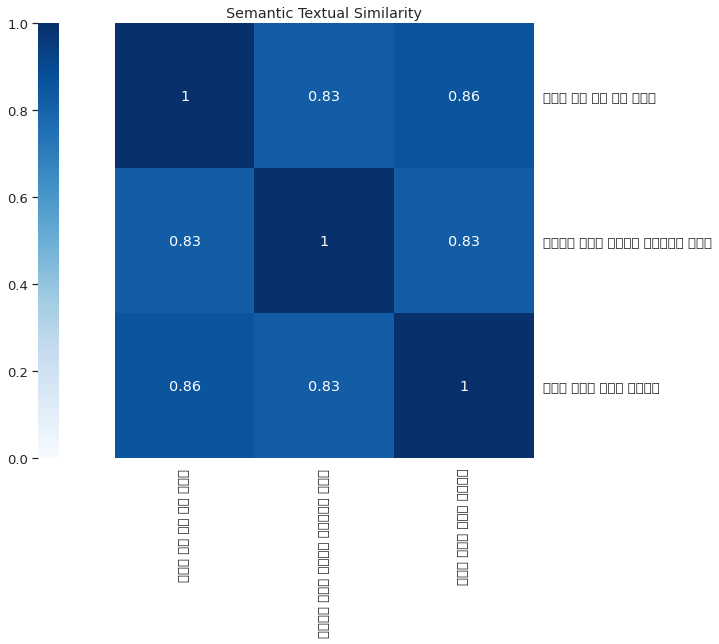

In [58]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothic') 

reviews = ["좋아요 처음 구입 싸게 했어요",
           "튼튼하고 좋아요 깔끔하게 정리되어서 좋아요",
           "재구매 좋어요 좋아요 네네네요"]

# https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder_lite?hl=ko
plot_similarity(get_embeddings(reviews), reviews)

METRICS: accuracy, recall, precision, f1_score

In [21]:
from keras import backend as K

# METRICS[0]: accuracy
# tf.keras.metrics.CategoricalAccuracy(name="accuracy")

# METRICS[1]: balanced_recall
def balanced_recall(y_true, y_pred):
    """This function calculates the balanced recall metric
    recall = TP / (TP + FN)
    """
    recall_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true_class, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        recall_by_class = recall_by_class + recall
    return recall_by_class / y_pred.shape[1]

# METRICS[2]: balanced_precision
def balanced_precision(y_true, y_pred):
    """This function calculates the balanced precision metric
    precision = TP / (TP + FP)
    """
    precision_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_class, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        precision_by_class = precision_by_class + precision
    # return average balanced metric for each class
    return precision_by_class / y_pred.shape[1]

# METRICS[3]: balanced_f1_score
def balanced_f1_score(y_true, y_pred):
    """This function calculates the F1 score metric"""
    precision = balanced_precision(y_true, y_pred)
    recall = balanced_recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))    

### 3. 모델 생성 및 훈련


In [41]:
import tensorflow as tf

i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='reviews')
x = preprocessor(i)
x = encoder(x)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
# Output Dim. = num_classes
x = tf.keras.layers.Dense(num_classes, activation='softmax', name="output")(x)

model = tf.keras.Model(i, x)

In [43]:
n_epochs = 20

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
      balanced_recall,
      balanced_precision,
      balanced_f1_score
]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 3,
                                                      restore_best_weights = True)

# loss = tf.keras.losses.CategoricalCrossentropy(axis=1)
model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)

# ['reviews_hanspell']
model_fit = model.fit(X_train, 
                      y_train, 
                      epochs = n_epochs,
                      validation_data = (X_valid, y_valid),
                      callbacks = [earlystop_callback])

Epoch 1/20
625/625 [==============================] - 283s 426ms/step - loss: 0.9902 - accuracy: 0.6004 - balanced_recall: 0.2336 - balanced_precision: 0.3137 - balanced_f1_score: 0.2624 - val_loss: 0.8816 - val_accuracy: 0.6439 - val_balanced_recall: 0.3000 - val_balanced_precision: 0.3245 - val_balanced_f1_score: 0.3076
Epoch 2/20
625/625 [==============================] - 264s 422ms/step - loss: 0.8857 - accuracy: 0.6377 - balanced_recall: 0.3012 - balanced_precision: 0.3625 - balanced_f1_score: 0.3254 - val_loss: 0.8516 - val_accuracy: 0.6535 - val_balanced_recall: 0.3189 - val_balanced_precision: 0.3629 - val_balanced_f1_score: 0.3351
Epoch 3/20
625/625 [==============================] - 263s 421ms/step - loss: 0.8662 - accuracy: 0.6449 - balanced_recall: 0.3202 - balanced_precision: 0.3742 - balanced_f1_score: 0.3420 - val_loss: 0.8483 - val_accuracy: 0.6441 - val_balanced_recall: 0.3098 - val_balanced_precision: 0.3906 - val_balanced_f1_score: 0.3435
Epoch 4/20
625/625 [========

### 4. 모델 결과 확인




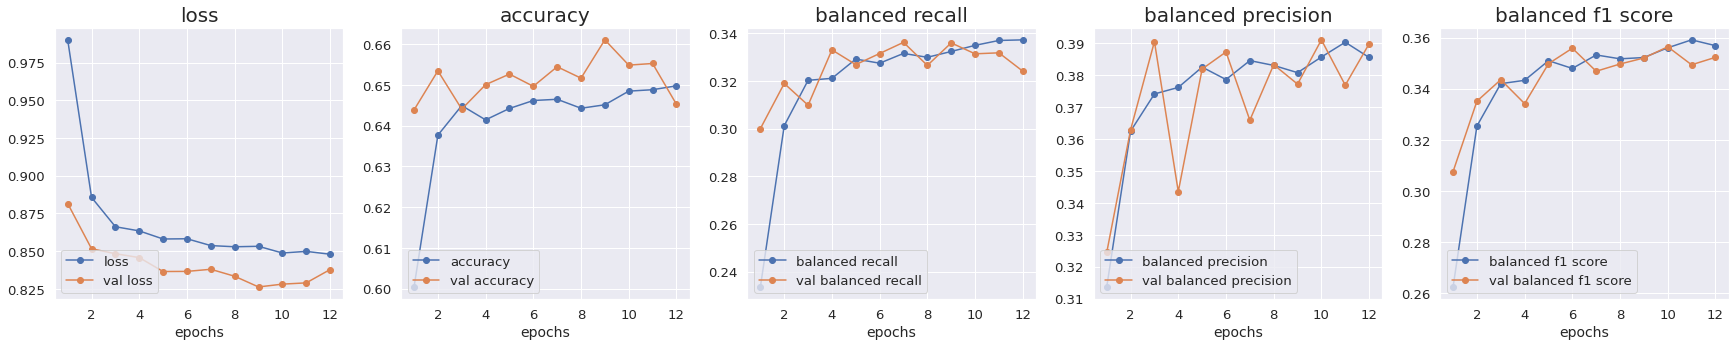

In [50]:
metric_list = list(model_fit.history.keys())
num_metrics = int(len(metric_list)/2)
x = list(range(1, len(model_fit.history[metric_list[i]])+1))

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, model_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, model_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")

predict 테스트

In [52]:
# test prediction on some newly generated reviews
review_samples = [
    "이 제품은 가성비가 좋다"
    ]

# observe translated samples
print('pred_target=', np.argmax(model.predict(review_samples)[0])+1)

1/1 [==============================] - 0s 61ms/step
pred_target= 5


predict 생성

In [53]:
def predict_class(reviews):
  '''predict class of input text
  Args:
    - reviews (list of strings)
  Output:
    - class (list of int)
  '''
  return [np.argmax(pred)+1 for pred in model.predict(reviews)]


# 예측값 후처리: pred_cate => pred_target
# 후처리 예제 np.argmax([0.0, 0.0, 0.0, 0.0, 1.0])+1 => 5 

pred_target = np.array(predict_class(train_df['reviews_hanspell']), dtype='int8')
print( pred_target.dtype, np.shape(pred_target), pred_target[0] )

# 예측값 저장
train_df['pred_target'] = pred_target
train_df.head()

781/781 [==============================] - 249s 318ms/step
int8 (24988,) 5


,id,reviews,target,reviews_hanspell,tkn_size,chr_size,label,pred_target
0,0,조아요 처음구입 싸게햇어요,2,좋아요 처음 구입 싸게 했어요,5,12,1,5
1,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 ...,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데 천 원가량 주고 사기 너무 아깝네요,13,35,0,1
2,2,디자인은괜찮은데 상품이 금이가서 교환했는데 두번째받은상품도 까져있고 안쪽에 금이가져...,2,디자인은 괜찮은데 상품이 금이 가서 교환했는데 두 번째 받은 상품도 까져있고 안쪽에...,19,64,1,2
3,3,기전에 이 제품말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다. 샘...,2,기전에 이 제품 말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다 샘...,36,102,1,5
4,4,튼튼하고 손목을 잘 받쳐주네요~,5,튼튼하고 손목을 잘 받쳐주네요,4,13,4,5


   rating  pred_target_cnt  real_target_cnt
0       1           1777.0           4499.0
1       2          11121.0           7994.0
2       3              NaN              NaN
3       4            129.0           2500.0
4       5          11961.0           9995.0



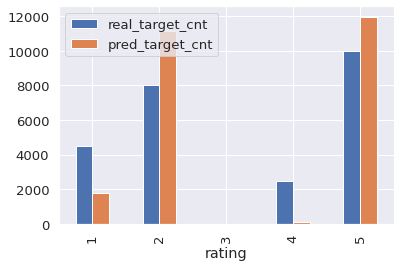

In [81]:
# 예측값
bar1 = train_df.groupby('pred_target').count()['id']
frame = { 'rating': bar1.index, 'pred_target_cnt': bar1.tolist() }
bar1_df = pd.merge( pd.DataFrame({'rating': range(1,num_classes+1)}), pd.DataFrame(frame), on="rating", how='left')

bar2 = train_df.groupby('target').count()['id']
frame = { 'rating': bar2.index, 'real_target_cnt': bar2.tolist() }
bar2_df = pd.merge( pd.DataFrame({'rating': range(1,num_classes+1)}), pd.DataFrame(frame), on="rating", how='left')

# inner join
bar_df = pd.merge(bar1_df, bar2_df, on="rating")

print( bar_df.head(), end='\n\n' )
bar_df.plot(x="rating", y=["real_target_cnt", "pred_target_cnt"], kind="bar")


### 5. 모델 활용(예측/분류)

- 데이터 불러오기: test_df
- 동일한 전처리와 벡터화 적용
- predict


In [68]:
import pandas as pd

data_path = "/gdrive/MyDrive/Colab Notebooks/제주ICT-AI분석반-쇼핑몰분석/data"

# 맞춤법/띄어쓰기 전처리 파일 
test_df = pd.read_csv(f'{data_path}/test_hanspell.csv')
test_df

,id,reviews,reviews_hanspell,tkn_size,chr_size
0,0,채소가 약간 시들어 있어요,채소가 약간 시들어 있어요,4,11
1,1,발톱 두껍고 단단한 분들 써도 소용없어요 이 테이프 물렁거리고 힘이없어서 들어 올리...,발톱 두껍고 단단한 분들 써도 소용없어요 이 테이프 물렁거리고 힘이 없어서 들어 올...,21,56
2,2,부들부들 좋네요 입어보고 시원하면 또 살게요,부들부들 좋네요 입어보고 시원하면 또 살게요,6,19
3,3,이런 1. 8 골드 주라니깐 파란개 오네 회사전화걸어도 받지도 않고 머하자는거임?,이런 골드 주라니깐 파란 개 오네 회사 전화 걸어도 받지도 않고 머 하자는 거임,14,31
4,4,검수도 없이 보내구 불량 배송비 5000원 청구하네요 완전별로 별하나도 아까워요,검수도 없이 보내고 불량 배송비 원 청구하네요 완전별로 별 하나도 아까워요,11,31
...,...,...,...,...,...
24987,24995,사용해보니 좋아요~^^,사용해보니 좋아요,2,8
24988,24996,저렴한가격에. 질좋고. 핏좋고. 너무. 이쁘게. 입고다녀요..,저렴한 가격에 질 좋고 핏좋고 너무 이쁘게 입고 다녀요,9,22
24989,24997,세트상품이라고 써있어서 그런줄 알고 구매했더니 단품이었네요 낚인 느낌도 들고 그러네...,세트 상품이라고 쓰여있어서 그런 줄 알고 구매했더니 단품이었네요 낚인 느낌도 들고 ...,27,80
24990,24998,역시 로네펠트!! 좋아요.,역시 로네펠트 좋아요,3,9


In [69]:
from sklearn.metrics import classification_report

# 예측값 생성, 후처리 ==> [1~5]
y_pred = predict_class(test_df["reviews_hanspell"])

781/781 [==============================] - 273s 351ms/step


In [73]:
np.array(y_pred, dtype='int8')

array([2, 2, 5, ..., 2, 5, 2], dtype=int8)

In [74]:
# 예측값 저장
test_df['pred_target'] = np.array(y_pred, dtype='int8')
test_df

,id,reviews,reviews_hanspell,tkn_size,chr_size,pred_target
0,0,채소가 약간 시들어 있어요,채소가 약간 시들어 있어요,4,11,2
1,1,발톱 두껍고 단단한 분들 써도 소용없어요 이 테이프 물렁거리고 힘이없어서 들어 올리...,발톱 두껍고 단단한 분들 써도 소용없어요 이 테이프 물렁거리고 힘이 없어서 들어 올...,21,56,2
2,2,부들부들 좋네요 입어보고 시원하면 또 살게요,부들부들 좋네요 입어보고 시원하면 또 살게요,6,19,5
3,3,이런 1. 8 골드 주라니깐 파란개 오네 회사전화걸어도 받지도 않고 머하자는거임?,이런 골드 주라니깐 파란 개 오네 회사 전화 걸어도 받지도 않고 머 하자는 거임,14,31,1
4,4,검수도 없이 보내구 불량 배송비 5000원 청구하네요 완전별로 별하나도 아까워요,검수도 없이 보내고 불량 배송비 원 청구하네요 완전별로 별 하나도 아까워요,11,31,1
...,...,...,...,...,...,...
24987,24995,사용해보니 좋아요~^^,사용해보니 좋아요,2,8,5
24988,24996,저렴한가격에. 질좋고. 핏좋고. 너무. 이쁘게. 입고다녀요..,저렴한 가격에 질 좋고 핏좋고 너무 이쁘게 입고 다녀요,9,22,5
24989,24997,세트상품이라고 써있어서 그런줄 알고 구매했더니 단품이었네요 낚인 느낌도 들고 그러네...,세트 상품이라고 쓰여있어서 그런 줄 알고 구매했더니 단품이었네요 낚인 느낌도 들고 ...,27,80,2
24990,24998,역시 로네펠트!! 좋아요.,역시 로네펠트 좋아요,3,9,5


### 6. 모델 시각화 (실제값/예측값)

- 예측값 시각화
- 실제값 시각화


   rating  pred_target_cnt  real_target_cnt  test_target_cnt
0       1           1777.0           4499.0           1743.0
1       2          11121.0           7994.0          11144.0
2       3              NaN              NaN              NaN
3       4            129.0           2500.0            132.0
4       5          11961.0           9995.0          11973.0



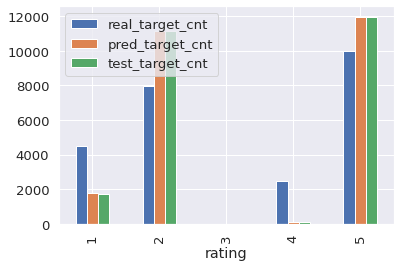

In [82]:
# 예측값
bar3 = test_df.groupby('pred_target').count()['id']
frame = { 'rating': bar3.index, 'test_target_cnt': bar3.tolist() }
bar3_df = pd.merge( pd.DataFrame({'rating': range(1,num_classes+1)}), pd.DataFrame(frame), on="rating", how='left')

# 막대그래프
# bar3_df.plot.bar(x="rating", y=["pred_target_cnt"], figsize=(10,4))

# inner join
bar_df = pd.merge(bar_df, bar3_df, on="rating")

print( bar_df.head(), end='\n\n' )
bar_df.plot(x="rating", y=["real_target_cnt", "pred_target_cnt", "test_target_cnt"], kind="bar")

### 7. 예측값 저장 (제출용)


In [83]:
data_path = "/gdrive/MyDrive/Colab Notebooks/제주ICT-AI분석반-쇼핑몰분석/data"

# 제출용 파일 불러오기
submission = pd.read_csv(f'{data_path}/sample_submission.csv') 
print(submission.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      25000 non-null  int64
 1   target  25000 non-null  int64
dtypes: int64(2)
memory usage: 390.8 KB
None


In [84]:
# 예측값을 제출용 DF과 합치기 (NaN값 포함)

# left join: drop 된 rows 은 NaN 처리
submission_pred = pd.merge( 
    submission, 
    test_df[['id','pred_target']], 
    on='id',
    how='left'       # left, outer, right
    )
print('after MERGE:', submission_pred.shape )

# left join 으로 인한 NaN 조회
print(submission_pred.isna().sum())

# NaN 행 확인 (8개 행 맞음)
submission_pred[ submission_pred.isna().any(axis=1) ]

# merge 되면서 pred_target 이 float 로 바뀌었음 (왜지?)

# df1.join(df2) : 기본적으로 left join
# pd.merge(df1, df2, left_index=True, right_index=True) : 기본 inner join
# pd.concat([df1, df2], axis=1) : 기본 outer join

after MERGE: (25000, 3)
id             0
target         0
pred_target    8
dtype: int64


,id,target,pred_target
2989,2989,0,NaN
6621,6621,0,NaN
10889,10889,0,NaN
10901,10901,0,NaN
11422,11422,0,NaN
11881,11881,0,NaN
21228,21228,0,NaN
23708,23708,0,NaN


In [85]:
# NaN 값을 포함한 컬럼의 형 변환시에는
# nullable 가능한 pd.Int64Dtype() 으로 바꿔야 가능
submission_pred['target'] = submission_pred['pred_target'].astype('Int8')

# 기존 target 컬럼 삭제
submission_pred = submission_pred.drop(columns=['pred_target'])

# 확인
submission_pred.dtypes

# **참고: 컬럼 이름 변경 
# submission_pred = submission_pred.rename(columns={'pred_target' : 'target'})

id        int64
target     Int8
dtype: object

In [87]:
import pandas as pd
data_path="/gdrive/MyDrive/Colab Notebooks/제주ICT-AI분석반-쇼핑몰분석/data"
file_name="submission_v7.1-translate_hanspell"

# submission.csv 저장
submission_pred.to_csv(f'{data_path}/{file_name}.csv', index=False, encoding='utf-8')

# ==> 채점 0.64896

In [88]:
# 다운로드 (구글 드라이브에서 안보여도 가능)
from google.colab import files
files.download( f'{data_path}/{file_name}.csv' ) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>